In [102]:
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import pipeline
from scipy.special import softmax
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2
plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## NLP Models ##

### DistilRoBERTa Financial Sentiment Model ###

A fine-tuned version of DistilRoberta base model on the Financial PhraseBank dataset.

https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis

In [3]:
model_DistRoBERTa = f"mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
_sentiment_analysis_DistRoBERTa = pipeline("sentiment-analysis",
                                           model=AutoModelForSequenceClassification.from_pretrained(model_DistRoBERTa),
                                           tokenizer=AutoTokenizer.from_pretrained(model_DistRoBERTa))

### FinBERT ###

A pre-traned NLP model to analyze sentiment of financial text.
The BERT model fine-tuned on the Financial PhraseBank dataset.

https://huggingface.co/ProsusAI/finbert

In [4]:
model_FinBERT = "ProsusAI/finbert"
_sentiment_analysis_FinBERT = pipeline("sentiment-analysis",
                                       model=AutoModelForSequenceClassification.from_pretrained(model_FinBERT),
                                       tokenizer=AutoTokenizer.from_pretrained(model_FinBERT))

### FinDeBERTa ###

A fine-tuned version of DeBERTa base model on the None dataset.

https://huggingface.co/mrm8488/deberta-v3-ft-financial-news-sentiment-analysis

In [5]:
model_DeBERTa = f"mrm8488/deberta-v3-ft-financial-news-sentiment-analysis"
_sentiment_analysis_DeBERTa = pipeline("sentiment-analysis",
                                        model=AutoModelForSequenceClassification.from_pretrained(model_DeBERTa),
                                        tokenizer=AutoTokenizer.from_pretrained(model_DeBERTa))

## Functions ##

In [127]:
def validate_predictions(df, tar, sco, model, neutral_factor=1, debug=False):
    """
    Validate prediction based on adaptive volatility-based threshold for neutrality.

    Args:
        df (pd.DataFrame): DataFrame containing stock data with calculated volatility.
        tar (str): Column name for the target price change (e.g., 'Daily Return').
        sco (str): Column name for the sentiment score.
        model (str): Model name to include in the predictions column.
        neutral_factor (float): Multiplier for volatility to define the neutral threshold.
        debug (bool): If True, logs details of failures.

    Returns:
        pd.DataFrame: DataFrame with predictions and success/failure of predictions.
    """
    predict_dict = {}
    fail = {}
    n = 0

    # Validate input columns exist
    required_cols = [tar, sco, 'Volatility']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Calculate adaptive volatility threshold and predictions
    for i, row in tqdm(df.iterrows(), total=len(df), disable=not debug):
        try:
            target = row[tar]
            score = row[sco]

            # Handle NaN values
            if pd.isna(target) or pd.isna(score) or pd.isna(row['Volatility']):
                predict_dict[i] = 0  # or another default value for NaN cases
                continue

            volatility_threshold = abs(row['Volatility'] * neutral_factor)  # Add abs() for safety

            # Improved prediction logic
            if abs(target) > volatility_threshold:
                # Only evaluate directional accuracy when both target and score are non-zero
                if target != 0 and score != 0:
                    predict_dict[i] = 1 if (target * score) > 0 else 0  # Simplified comparison
                else:
                    predict_dict[i] = 0  # Case where either value is zero
            else:
                # Modified neutral case logic
                predict_dict[i] = 1 if abs(score) < volatility_threshold else 0

        except KeyError as e:
            if debug:
                print(f"KeyError at index {i}: {str(e)}")
            predict_dict[i] = 0
        except Exception as e:
            if debug:
                fail[n] = {'index': i, 'error': str(e)}
                n += 1
            predict_dict[i] = 0

    # Create the predictions DataFrame more efficiently
    predictions = pd.Series(predict_dict, name=f"{model}_predictions")

    # Update the DataFrame more efficiently
    if predictions.name in df.columns:
        df = df.drop(columns=[predictions.name])
    df = df.join(predictions)

    if debug:
        return df, fail
    else:
        return df

In [22]:
def get_sentiment_scores(df, news, model, debug=False):
    """
    Performs sentiment analysis using a specified pipeline and calculates sentiment scores.

    Args:
        df (pd.DataFrame): DataFrame containing the text data.
        news (str): Column name for the news headlines or text to analyze.
        model (str): The model to use for sentiment analysis ('DistRoBERTa', 'FinBERT', 'DeBERTa').
        debug (bool): If True, logs details of failures.

    Returns:
        pd.DataFrame: DataFrame with calculated sentiment scores.
    """
    # Select the appropriate model pipeline
    if model == "DistRoBERTa":
        sent_pipeline = _sentiment_analysis_DistRoBERTa
    elif model == "FinBERT":
        sent_pipeline = _sentiment_analysis_FinBERT
    elif model == "DeBERTa":
        sent_pipeline = _sentiment_analysis_DeBERTa
    else:
        raise ValueError("Invalid model name. Choose 'DistRoBERTa', 'FinBERT', 'DeBERTa'.")

    res = {}
    fail = {}
    n = 0

    # Process each row in the DataFrame
    for i, row in tqdm(df.iterrows(), total=len(df)):
        text = row[news]
        try:
            if pd.isna(text):
                roberta_result = [{
                    'label': 'neutral',
                    'score': 1
                }]
            else:
                roberta_result = sent_pipeline(text[:514])

        except (IndexError, RuntimeError):
            if pd.isna(text) and debug:
                fail[n] = str(i)
            elif debug:
                fail[n] = text
                n += 1
            roberta_result = [{
                'label': 'neutral',
                'score': 0
            }]
            pass
        res[i] = roberta_result

    # Convert results to DataFrame
    res = pd.DataFrame(res).T
    res = res[0].apply(pd.Series)
    res.columns = ['label', 'score']

    # Calculate sentiment score with intensity and replace if column exists
    sentiment_score_col = f"{model}_sentiment_score"
    res[sentiment_score_col] = res.apply(
        lambda x: -x['score'] if x['label'] == 'negative'
        else (x['score'] if x['label'] == 'positive' else 0),
        axis=1
    )

    # Merge with original DataFrame, dropping the column if it already exists
    if sentiment_score_col in df.columns:
        df = df.drop(columns=[sentiment_score_col])
    df = pd.merge(df, res[sentiment_score_col], left_index=True, right_index=True)

    if debug:
        return df, fail
    else:
        return df

In [23]:
def process_stock_data(input_file, output_file):
    """
    Process stock data by calculating 'Tomorrow' and 'Target' columns, then save to a file.

    Parameters:
    - input_file: Path to the input CSV file.
    - output_file: Path to save the processed CSV file.
    """
    try:
        # Read the CSV file
        data = pd.read_csv(input_file)

        # Drop any columns containing 'unnamed' (in case of unnamed index columns)
        data.drop(data.columns[data.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)

        # Check for required columns
        required_columns = ["High", "Low"]
        if not all(column in data.columns for column in required_columns):
            raise ValueError(f"Missing required columns: {', '.join([col for col in required_columns if col not in data.columns])}")

        # Calculate 'Tomorrow' and 'Target' columns
        data["Tomorrow"] = (data["High"].shift(-1) + data["Low"].shift(-1)) / 2
        data["Target"] = (data["Tomorrow"] / ((data["High"] + data["Low"]) / 2) - 1)

        # Save the processed data to a CSV file
        data.to_csv(output_file, index=False)
        print(f"Processed data saved to {output_file}")

    except FileNotFoundError:
        print(f"Error: The file '{input_file}' was not found.")
    except ValueError as ve:
        print(f"Error: {ve}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [124]:
def calculate_volatility(df, window=5, return_column='Daily Return', trading_days=252):
    """
    Calculate rolling volatility of returns.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the return data
    window : int, default=5
        Rolling window for volatility calculation (in days)
    return_column : str, default='Daily Return'
        Name of the column containing returns
    trading_days : int, default=252
        Number of trading days in a year, used for annualization

    Returns:
    --------
    pandas.DataFrame
        Original DataFrame with new columns for:
        - Daily volatility
        - Annualized volatility
        - Rolling volatility (based on window parameter)
    """

    # Calculate daily returns if not already present
    if return_column not in df.columns:
        df['Daily Return'] = df['Close'].pct_change()
        return_column = 'Daily Return'

    # Calculate daily volatility (standard deviation of returns)
    df['Daily Volatility'] = df[return_column].std()

    # Calculate annualized volatility
    df['Annualized Volatility'] = df['Daily Volatility'] * np.sqrt(trading_days)

    # Calculate rolling volatility
    df['Volatility'] = (
        df[return_column]
        .rolling(window=window)
        .std() * np.sqrt(trading_days)
    )

    # # Create a summary dictionary
    # volatility_summary = {
    #     'Mean Daily Return': df[return_column].mean(),
    #     'Daily Volatility': df['Daily Volatility'].iloc[0],  # Using first value since it's constant
    #     'Annualized Volatility': df['Annualized Volatility'].iloc[0],  # Using first value since it's constant
    #     'Rolling Volatility (Latest)': df[f'{window}d Rolling Volatility'].iloc[-1],
    #     'Rolling Volatility (Max)': df[f'{window}d Rolling Volatility'].max(),
    #     'Rolling Volatility (Min)': df[f'{window}d Rolling Volatility'].min(),
    # }

    return df#, volatility_summary

In [175]:
def find_best_threshold(data, score_column, prediction_column, model_name, start_threshold=0, end_threshold=1, min_increment=0.01):
    """
    Optimized function to find the best threshold for sentiment score predictions using iterative refinement.

    Args:
        data (pd.DataFrame): The DataFrame containing the stock and sentiment data.
        score_column (str): The name of the column containing sentiment scores.
        prediction_column (str): The name of the column containing prediction values (0 or 1).
        model_name (str): The name of the sentiment model used.
        start_threshold (float): The starting threshold (default is 0).
        end_threshold (float): The ending threshold (default is 1).
        min_increment (float): The minimum increment to consider (default is 0.01).

    Returns:
        tuple: The best threshold and the corresponding score.
    """
    def evaluate_threshold(threshold):
        """Helper function to evaluate a single threshold value"""
        temp_data = validate_predictions(data.copy(), 'Target', score_column, model_name, threshold)
        return sum(temp_data[prediction_column]) / len(temp_data.index)

    best_threshold = start_threshold
    best_score = 0.0
    current_start = start_threshold
    current_end = end_threshold

    # Continue refining until the increment becomes too small
    refinement_level = 1
    while True:
        # Calculate current increment as 10% of current range
        current_increment = (current_end - current_start) * 0.1

        # Stop if increment becomes too small
        if current_increment <= min_increment:
            # Final fine-tuning with minimum increment
            final_range = np.arange(current_start, current_end + min_increment, min_increment)
            for threshold in tqdm(final_range,
                                desc=f"Final refinement (increment={min_increment:.4f})",
                                leave=True):
                current_score = evaluate_threshold(threshold)
                if current_score > best_score:
                    best_score = current_score
                    best_threshold = threshold
            break

        # Create threshold range for this iteration
        thresholds = np.arange(current_start, current_end + current_increment, current_increment)

        # Evaluate each threshold in the current range
        local_best_threshold = best_threshold
        local_best_score = best_score

        for threshold in tqdm(thresholds,
                            desc=f"Refinement level {refinement_level} (increment={current_increment:.4f})",
                            leave=True):
            current_score = evaluate_threshold(threshold)
            if current_score > local_best_score:
                local_best_score = current_score
                local_best_threshold = threshold

        # Update best overall if better found
        if local_best_score > best_score:
            best_score = local_best_score
            best_threshold = local_best_threshold

        # Update range for next iteration
        # New range is ±10% around the best threshold found
        range_width = current_increment * 2  # Look one increment on either side
        current_start = max(start_threshold, best_threshold - range_width)
        current_end = min(end_threshold, best_threshold + range_width)

        refinement_level += 1

    return best_threshold, best_score

In [148]:
def create_sentiment_plot(df, size=5):
    fig = go.Figure()

    # Define color schemes for each model: (true_color, false_color)
    color_schemes = {
        'DistRoBERTa': ('#2ecc71', '#a9dfbf'),  # Green shades
        'FinBERT': ('#3498db', '#aed6f1'),      # Blue shades
        'DeBERTa': ('#9b59b6', '#d7bde2')       # Purple shades
    }

    sentiment_models = [
        ('DistRoBERTa', 'DistRoBERTa_sentiment_score', 'DistRoBERTa_predictions'),
        ('FinBERT', 'FinBERT_sentiment_score', 'FinBERT_predictions'),
        ('DeBERTa', 'DeBERTa_sentiment_score', 'DeBERTa_predictions')
    ]

    for model_name, score_col, pred_col in sentiment_models:
        # Get color scheme for this model
        true_color, false_color = color_schemes[model_name]

        # Create scatter plot for each prediction value (0 and 1)
        for pred_value in [0, 1]:
            mask = df[pred_col] == pred_value

            fig.add_trace(
                go.Scatter(
                    x=df[mask].index,
                    y=df[mask][score_col],
                    name=f'{model_name} (Pred={pred_value})',
                    mode='markers',  # Removed 'lines' to show only markers
                    marker=dict(
                        color=true_color if pred_value == 1 else false_color,
                        size=10,
                        symbol='circle'
                    )
                )
            )

    fig.update_layout(
        title='Sentiment Scores Over Time by Model',
        xaxis_title='Date',
        yaxis_title='Sentiment Score',
        template='plotly_white',
        hovermode='x unified',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True)
    )
    fig.update_traces(marker=dict(size=size))
    return fig

## Read Data ##

In [7]:
# process_stock_data('/tmp/pycharm_project_520/src/data/input/raw/source_1/AppleNewsStock.csv', '/tmp/pycharm_project_520/src/data/input/processed/source_1/AppleNewsStock.csv')
# process_stock_data('/tmp/pycharm_project_520/src/data/input/raw/source_1/MicrosoftNewsStock.csv', '/tmp/pycharm_project_520/src/data/input/processed/source_1/MicrosoftNewsStock.csv')

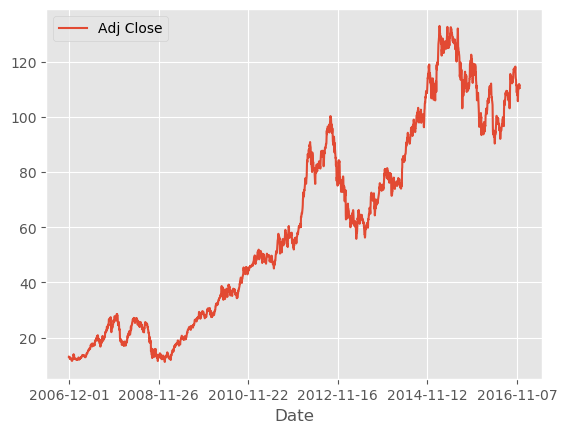

In [10]:
aapl_data = pd.read_csv('/tmp/pycharm_project_520/src/data/input/processed/source_1/AppleNewsStock.csv')
aapl_data.plot.line(y="Adj Close", x='Date')

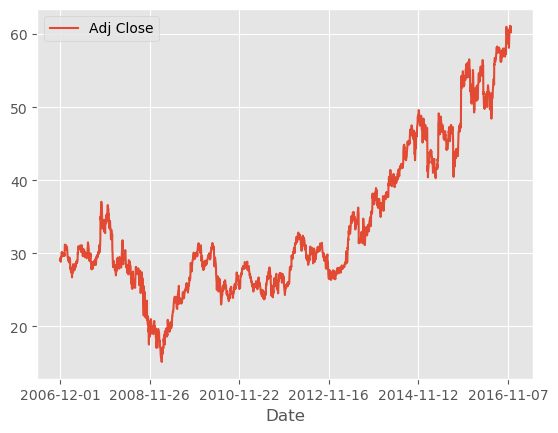

In [11]:
msft_data = pd.read_csv('/tmp/pycharm_project_520/src/data/input/processed/source_1/MicrosoftNewsStock.csv')
msft_data.plot.line(y="Adj Close", x='Date')

# Sentiment Analysis

### -Microsoft

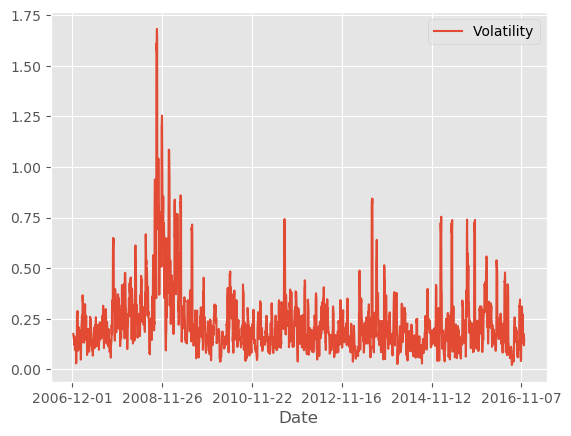

In [125]:
msft_data = calculate_volatility(msft_data)
msft_data.plot.line(y="Volatility", x='Date')

In [15]:
msft_data = get_sentiment_scores(msft_data, 'News', model="DistRoBERTa")

In [18]:
msft_data = get_sentiment_scores(msft_data, 'News', model="FinBERT")

In [12]:
msft_data = get_sentiment_scores(msft_data, 'News', model="DeBERTa")

In [197]:
msft_data = validate_predictions(msft_data, 'Target', 'DistRoBERTa_sentiment_score', "DistRoBERTa", 1)
(sum((msft_data['DistRoBERTa_predictions'])) / len(msft_data.index))

0.7226857369884784

In [198]:
msft_data = validate_predictions(msft_data, 'Target', 'FinBERT_sentiment_score', "FinBERT", 1)
(sum((msft_data['FinBERT_predictions'])) / len(msft_data.index))

0.8005562177195074

In [199]:
msft_data = validate_predictions(msft_data, 'Target', 'DeBERTa_sentiment_score', "DeBERTa", 1)
(sum((msft_data['DeBERTa_predictions'])) / len(msft_data.index))

0.8160508541914978

In [15]:
msft_data.to_csv('/tmp/pycharm_project_520/src/data/output/MicrosoftNewsStock.csv', index=False)

In [ ]:
find_best_threshold(msft_data,'DistRoBERTa_sentiment_score', 'DistRoBERTa_predictions', 'DistRoBERTa', start_threshold=0.0, end_threshold=1000000.0, min_increment=0.01)

In [ ]:
find_best_threshold(msft_data,'FinBERT_sentiment_score', 'FinBERT_predictions', 'FinBERT', start_threshold=0.0, end_threshold=1000000.0, min_increment=0.01)

In [ ]:
find_best_threshold(msft_data,'DeBERTa_sentiment_score', 'DeBERTa_predictions', 'DeBERTa', start_threshold=0.0, end_threshold=1000000.0, min_increment=0.01)

Read in the saved output

In [4]:
msft_data = pd.read_csv('/tmp/pycharm_project_520/src/data/output/MicrosoftNewsStock.csv')

### -Apple

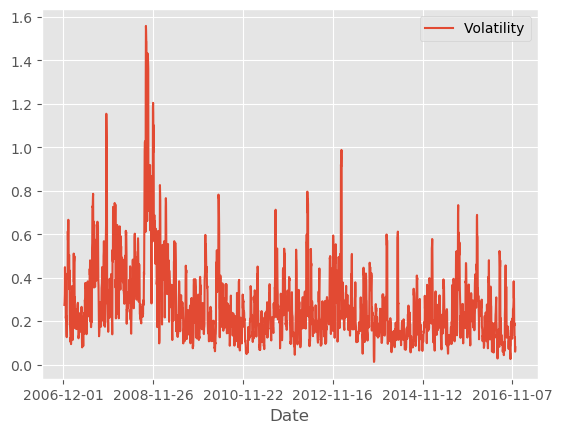

In [126]:
aapl_data = calculate_volatility(aapl_data)
aapl_data.plot.line(y="Volatility", x='Date')

In [27]:
aapl_data = get_sentiment_scores(aapl_data, 'News', model="DistRoBERTa")

In [28]:
aapl_data = get_sentiment_scores(aapl_data, 'News', model="FinBERT")

In [17]:
aapl_data = get_sentiment_scores(aapl_data, 'News', model="DeBERTa")

In [128]:
aapl_data = validate_predictions(aapl_data, 'Target', 'DistRoBERTa_sentiment_score', "DistRoBERTa", 9.99)
(sum((aapl_data['DistRoBERTa_predictions'])) / len(aapl_data.index))


0.545093365117203

In [129]:
aapl_data = validate_predictions(aapl_data, 'Target', 'FinBERT_sentiment_score', "FinBERT", )
(sum((aapl_data['FinBERT_predictions'])) / len(aapl_data.index))


0.7481128327373858

In [135]:

aapl_data = validate_predictions(aapl_data, 'Target', 'DeBERTa_sentiment_score', "DeBERTa", 0.99)
(sum((aapl_data['DeBERTa_predictions'])) / len(aapl_data.index))


0.7282479141835518

In [22]:
aapl_data.to_csv('/tmp/pycharm_project_520/src/data/output/AppleNewsStock.csv', index=False)

Read in the saved output

In [5]:
aapl_data = pd.read_csv('/tmp/pycharm_project_520/src/data/output/AppleNewsStock.csv')

# Plot Result Comparison #

In [196]:
fig = create_sentiment_plot(msft_data, size=4)
fig.show()

In [195]:
msft_data['Volatility']

AttributeError: 'Series' object has no attribute 'avg'

In [192]:
filtered_data = msft_data[msft_data['DeBERTa_sentiment_score'] != 1]
filtered_data = filtered_data[filtered_data['DeBERTa_predictions'] == 0]
print(filtered_data[['Target', 'DeBERTa_sentiment_score', 'DeBERTa_predictions']])

        Target  DeBERTa_sentiment_score  DeBERTa_predictions
0     0.008419                      0.0                    0
1    -0.004430                      0.0                    0
2    -0.007359                      0.0                    0
3    -0.002069                      0.0                    0
4     0.005529                      0.0                    0
2516       NaN                      0.0                    0


In [187]:
filtered_data = msft_data[msft_data['FinBERT_sentiment_score'] != 0]
filtered_data = filtered_data[filtered_data['FinBERT_predictions'] == 0]
print(filtered_data[['Target', 'FinBERT_sentiment_score', 'FinBERT_predictions']])

Empty DataFrame
Columns: [Target, FinBERT_sentiment_score, FinBERT_predictions]
Index: []


In [188]:
filtered_data = msft_data[msft_data['DistRoBERTa_sentiment_score'] != 0]
filtered_data = filtered_data[filtered_data['DistRoBERTa_predictions'] == 0]
print(filtered_data[['Target', 'DistRoBERTa_sentiment_score', 'DistRoBERTa_predictions']])

Empty DataFrame
Columns: [Target, DistRoBERTa_sentiment_score, DistRoBERTa_predictions]
Index: []


In [101]:
# Prepare the data for plotting
scores_and_predictions = [
    ("DistRoBERTa_sentiment_score", "DistRoBERTa_predictions"),
    ("FinBERT_sentiment_score", "FinBERT_predictions"),
    ("DeBERTa_sentiment_score", "DeBERTa_predictions"),
]

plot_data = pd.DataFrame()

# Combine sentiment scores and their predictions into one DataFrame
for score, prediction in scores_and_predictions:
    temp_df = msft_data[["Date", score, prediction]].rename(
        columns={score: "Value", prediction: "Prediction"}
    )
    temp_df["Metric"] = score
    plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

# Add a custom legend label combining type and prediction text
plot_data["Legend"] = plot_data.apply(
    lambda row: f"{row['Metric'].split('_')[0]} : {'true' if row['Prediction'] == 1 else 'false'}",
    axis=1,
)

# Assign distinct colors for each type-prediction combination
color_map = {
    "DistRoBERTa : false": "lightblue",
    "DistRoBERTa : true": "blue",
    "FinBERT : false": "lightgreen",
    "FinBERT : true": "green",
    "DeBERTa : false": "pink",
    "DeBERTa : true": "red",
}

# Map colors dynamically based on the Legend
plot_data["Color"] = plot_data["Legend"]

# Create the scatter plot
fig = px.scatter(
    plot_data,
    x="Date",
    y="Value",
    color="Legend",  # Map directly to 'Legend' for custom legend entries
    symbol="Metric",
    title="Sentiment Scores with Prediction-Based Colors",
    labels={"Value": "Sentiment Score", "Date": "Date", "Legend": "Type : Prediction", "Metric": "Metric"},
    color_discrete_map=color_map,
)

# Update layout for better visuals and make the plot wider
fig.update_xaxes(title_text="Date", tickangle=45)

# Set the legend title to "Type : Prediction"
fig.update_layout(
    legend_title_text="Type : Prediction",
    legend=dict(orientation="h", x=0.5, xanchor="center"),
    template="plotly_white",
    width=1200,  # Increase the width of the plot (default is 700)
)

# Adjust the size of the points (markers)
fig.update_traces(marker=dict(size=3))  # Set the size of the markers, 5 is a smaller size

# Show the plot
fig.show()


In [3]:
fig = px.scatter(data_frame=msft_data,
                 x='mrm8488_sentiment_score', y='Target', template='plotly_white',
                 width=500, height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()

NameError: name 'msft_data' is not defined

In [ ]:
fig = px.scatter(data_frame=msft_data,
                 x='ProsusAI_sentiment_score', y='Target', template='plotly_white',
                 width=500, height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()

In [ ]:
fig = px.scatter(data_frame=msft_data,
                 x='mrm8488_sentiment_score', y='ProsusAI_sentiment_score', template='plotly_white',
                 width=500, height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()

In [ ]:
fig = px.scatter(data_frame=aapl_data,
                 x='mrm8488_sentiment_score', y='Target', template='plotly_white',
                 width=500, height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()

In [ ]:
fig = px.scatter(data_frame=aapl_data,
                 x='ProsusAI_sentiment_score', y='Target', template='plotly_white',
                 width=500, height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()

In [ ]:
fig = px.scatter(data_frame=aapl_data,
                 x='mrm8488_sentiment_score', y='ProsusAI_sentiment_score', template='plotly_white',
                 width=500, height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()